In [1]:
from pyspark.context import SparkContext
from awsglue.context import GlueContext
import pyspark.sql.functions as F

In [2]:
glueContext = GlueContext(SparkContext.getOrCreate())
paradox_events = glueContext.create_dynamic_frame.from_catalog(
             database="my-home",
             table_name="paradox_events")
print("Count: {}".format(paradox_events.count()))
paradox_events.printSchema()

Count: 398935
root
|-- Casa: int
|-- partition_0: string
|-- partition_1: string
|-- partition_2: string
|-- partition_3: string
|-- timestamp: string
|-- event: string



In [3]:
df_events_count = paradox_events.toDF().groupBy('event').count().toPandas()

/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
df_events_count.set_index('event', inplace=True)
df_events_count.head()

count
event                     
Cucina-DOWN          54386
Giardino_Bagno-DOWN    628
Bagno_Vittorio-DOWN  18914
Garage-UP             1350
Camera_Bambini-UP    15311

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from itertools import cycle

In [6]:
img = Image.open("./40-Large-2-Bedroom-Apartment-Plan.jpg")

rooms = { 'Camera_Vittorio': (32,75), 
          'Camera_Bambini': (35,24), 
          'Bagno_Ospiti': (15,30),
          'Bagno_Vittorio': (25,52),
          'Soggiorno': (58,75),
          'Cucina': (80,25)
        }

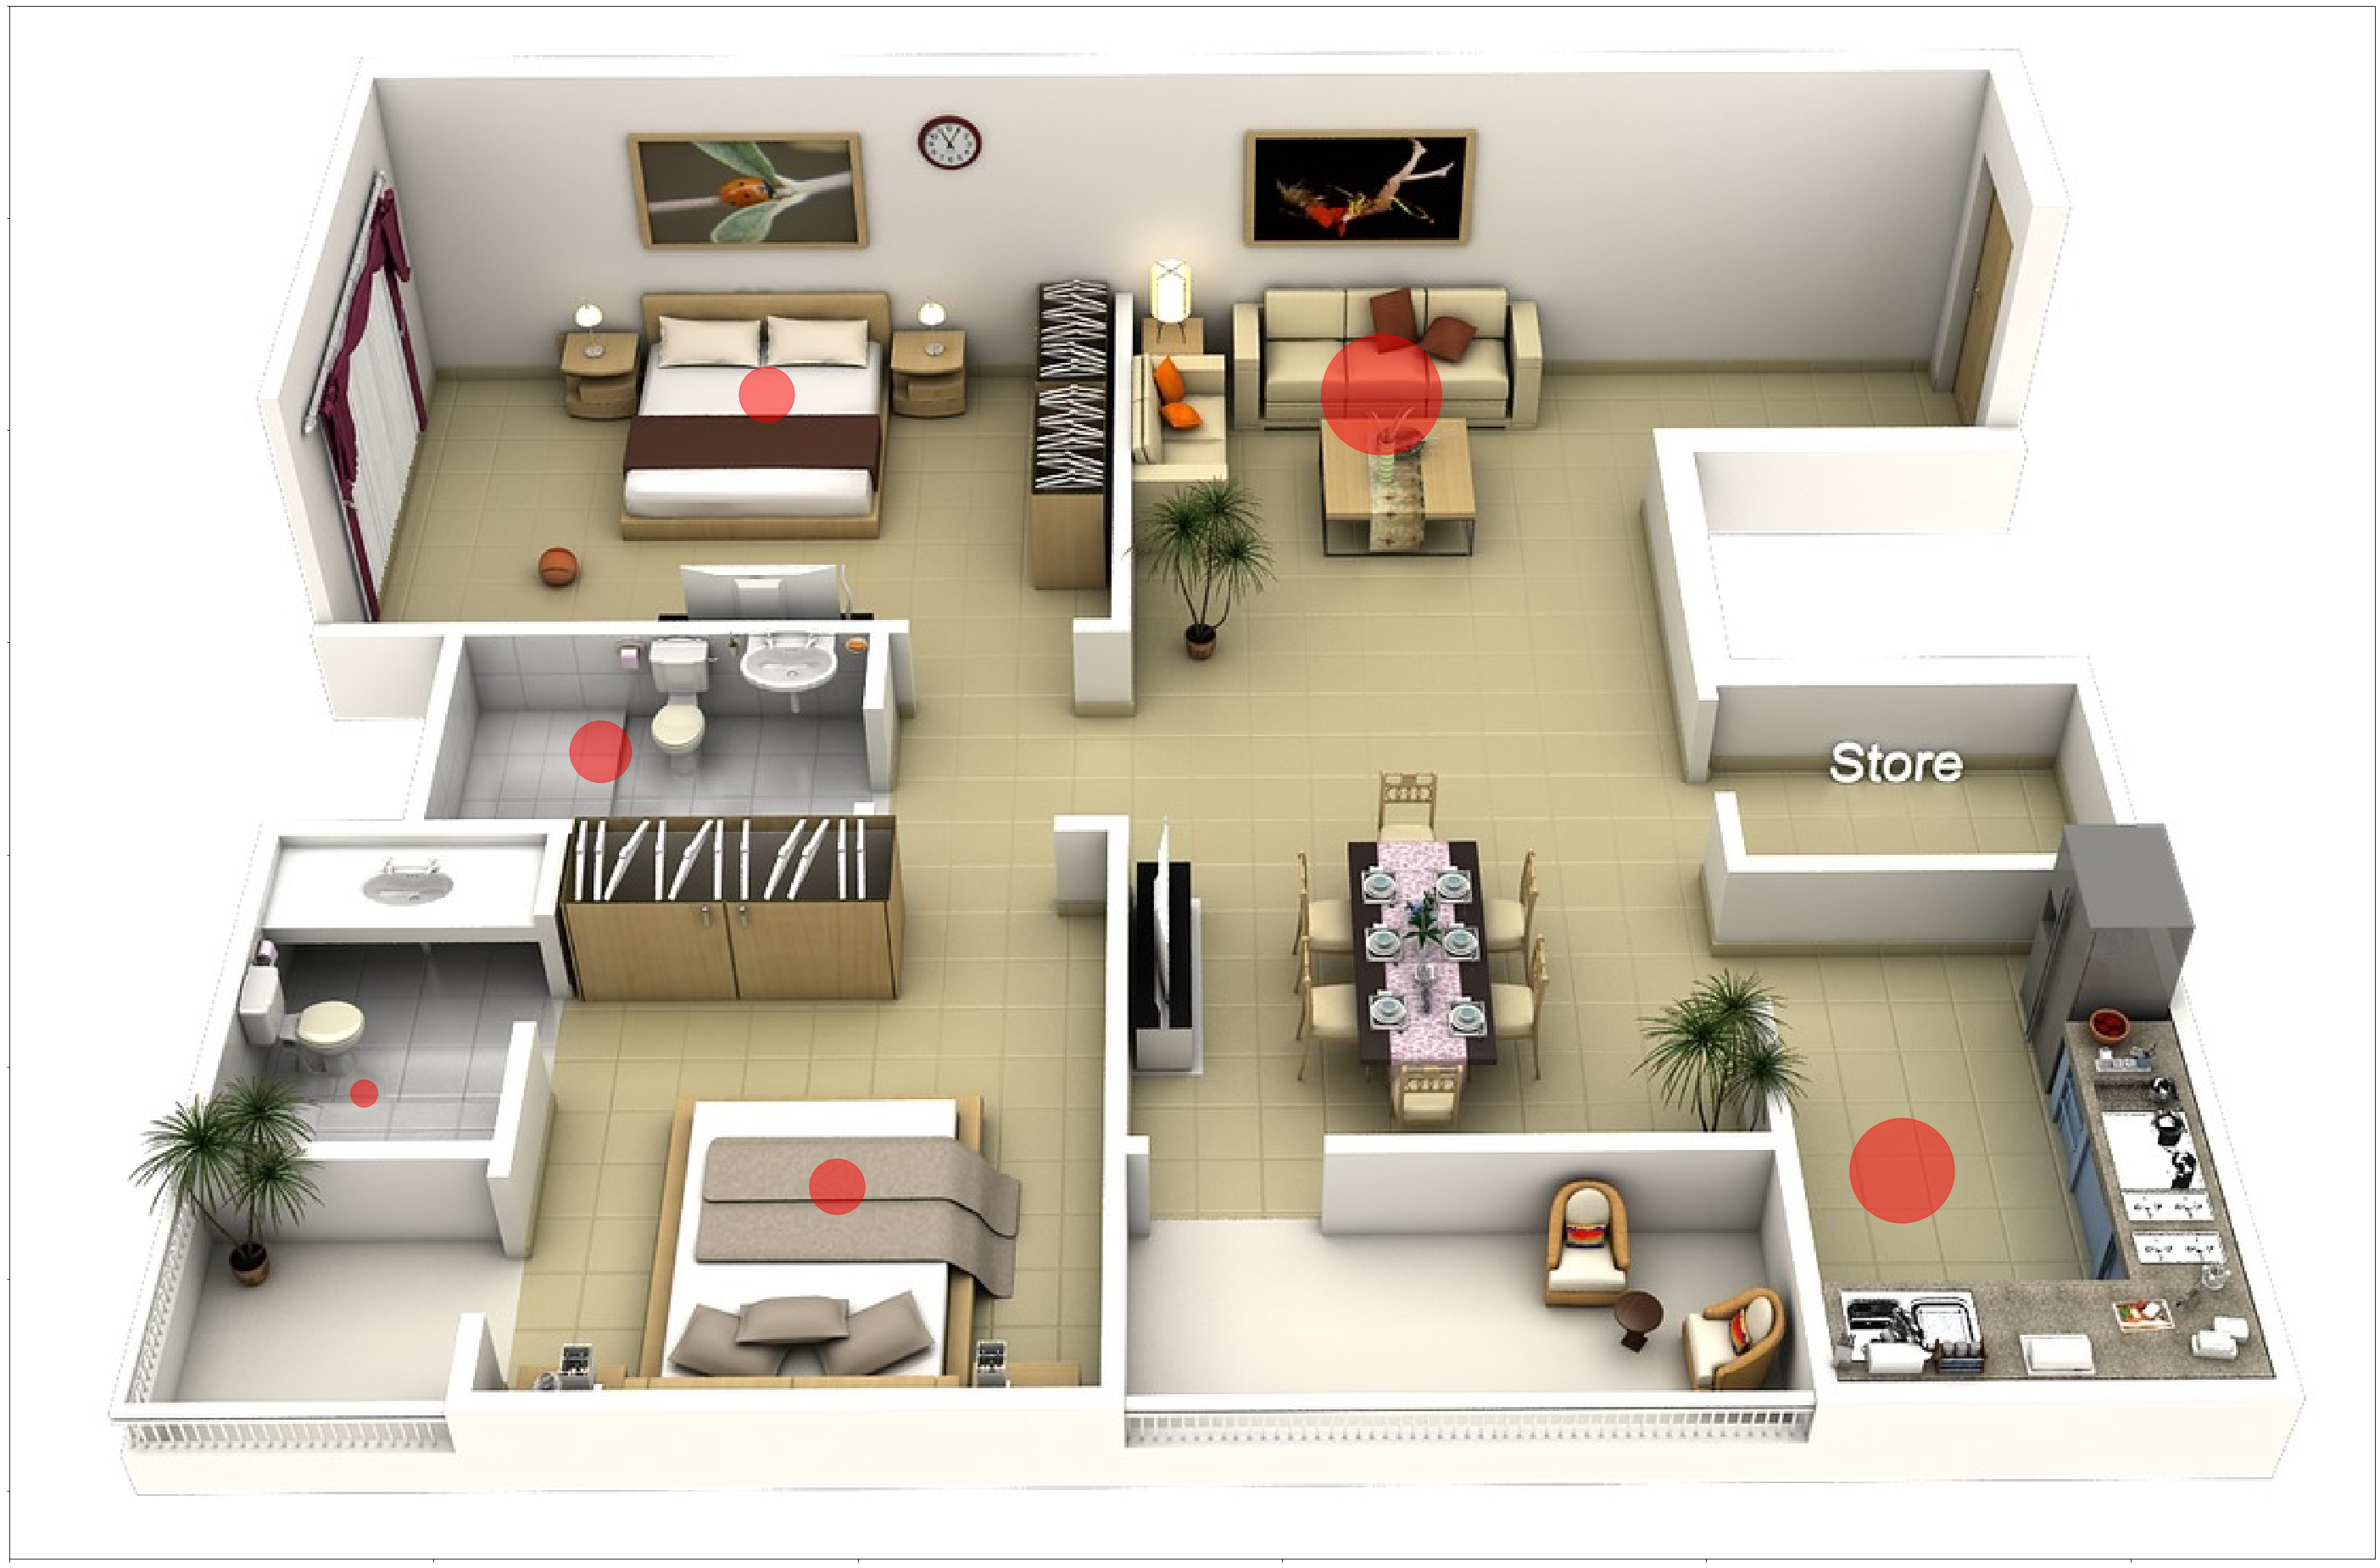

In [7]:
#
ticklx = np.linspace(0,100,5)
tickly = np.linspace(0,100,5)
xy2imgxy = lambda x,y: (img.size[0] * x / np.max(ticklx),\
                        img.size[1] * (np.max(tickly) - y) / np.max(tickly))
tickpx,tickpy = xy2imgxy(ticklx,tickly)

fig,ax = plt.subplots(figsize=(50,100))
ax.imshow(img)

# Rewrite x,y ticks lables
ax.set_xticklabels([])
ax.set_yticklabels([])

total = df_events_count['count'].sum()

# Add plot on the image.
for k in rooms:
    px,py = rooms[k]
    imgx,imgy = xy2imgxy(px,py)
    size = df_events_count.loc[k+'-UP']['count']/total*100
    ax.scatter(imgx,imgy,s=size*img.size[0],color="red",alpha=0.5)

# Adjust the axis.
ax.set_xlim(0,tickpx.max())
ax.set_ylim(tickpy.max(),0)

plt.show()

In [8]:
paradox_vectors = glueContext.create_dynamic_frame.from_catalog(
             database="my-home",
             table_name="paradox_vectors")
print("Count: {}".format(paradox_vectors.count()))
paradox_vectors.printSchema()

Count: 11104
root
|-- begin: string
|-- vector: array
|    |-- element: string



In [9]:
def remove_repeated_item_in_sequence(vector):
    result = []
    last_item = None
    for item in vector:
        if item != last_item:
            result.append(item)
        last_item = item
    return tuple(result)

df_vectors = paradox_vectors.toDF().toPandas()
df_vectors['vector'] = df_vectors['vector'].apply(remove_repeated_item_in_sequence)
df_vectors['vector_len'] = df_vectors['vector'].apply(lambda x: len(x))
df_vectors = df_vectors[df_vectors['vector_len'] > 1]

In [10]:
df_vectors.head()

begin                                             vector  \
0   2020-10-27 12:28:08.0  (Camera_Bambini-UP, Soggiorno-UP, Bagno_Vittor...   
1   2020-10-27 12:29:43.0  (Bagno_Vittorio-UP, Cucina-UP, Soggiorno-UP, C...   
2   2020-10-23 09:01:07.0            (Camera_Vittorio-UP, Camera_Bambini-UP)   
9   2020-10-23 16:23:15.0  (Camera_Bambini-UP, Camera_Vittorio-UP, Bagno_...   
10  2020-10-23 17:26:14.0       (Camera_Bambini-UP, Soggiorno-UP, Cucina-UP)   

    vector_len  
0            3  
1           30  
2            2  
9            6  
10           3

In [11]:
df_vectors_count = df_vectors.groupby(['vector','vector_len']).size().reset_index(name='counts')
df_vectors_count.sort_values(by='counts', ascending=False, inplace=True)
df_vectors_count.head()

vector  vector_len  counts
704            (Soggiorno-UP, Cucina-UP, Soggiorno-UP)           3     260
603    (Soggiorno-UP, Camera_Bambini-UP, Soggiorno-UP)           3     163
278  (Camera_Vittorio-UP, Soggiorno-UP, Bagno_Vitto...           3     145
173  (Camera_Bambini-UP, Soggiorno-UP, Camera_Bambi...           3     139
534    (Soggiorno-UP, Bagno_Vittorio-UP, Soggiorno-UP)           3     109

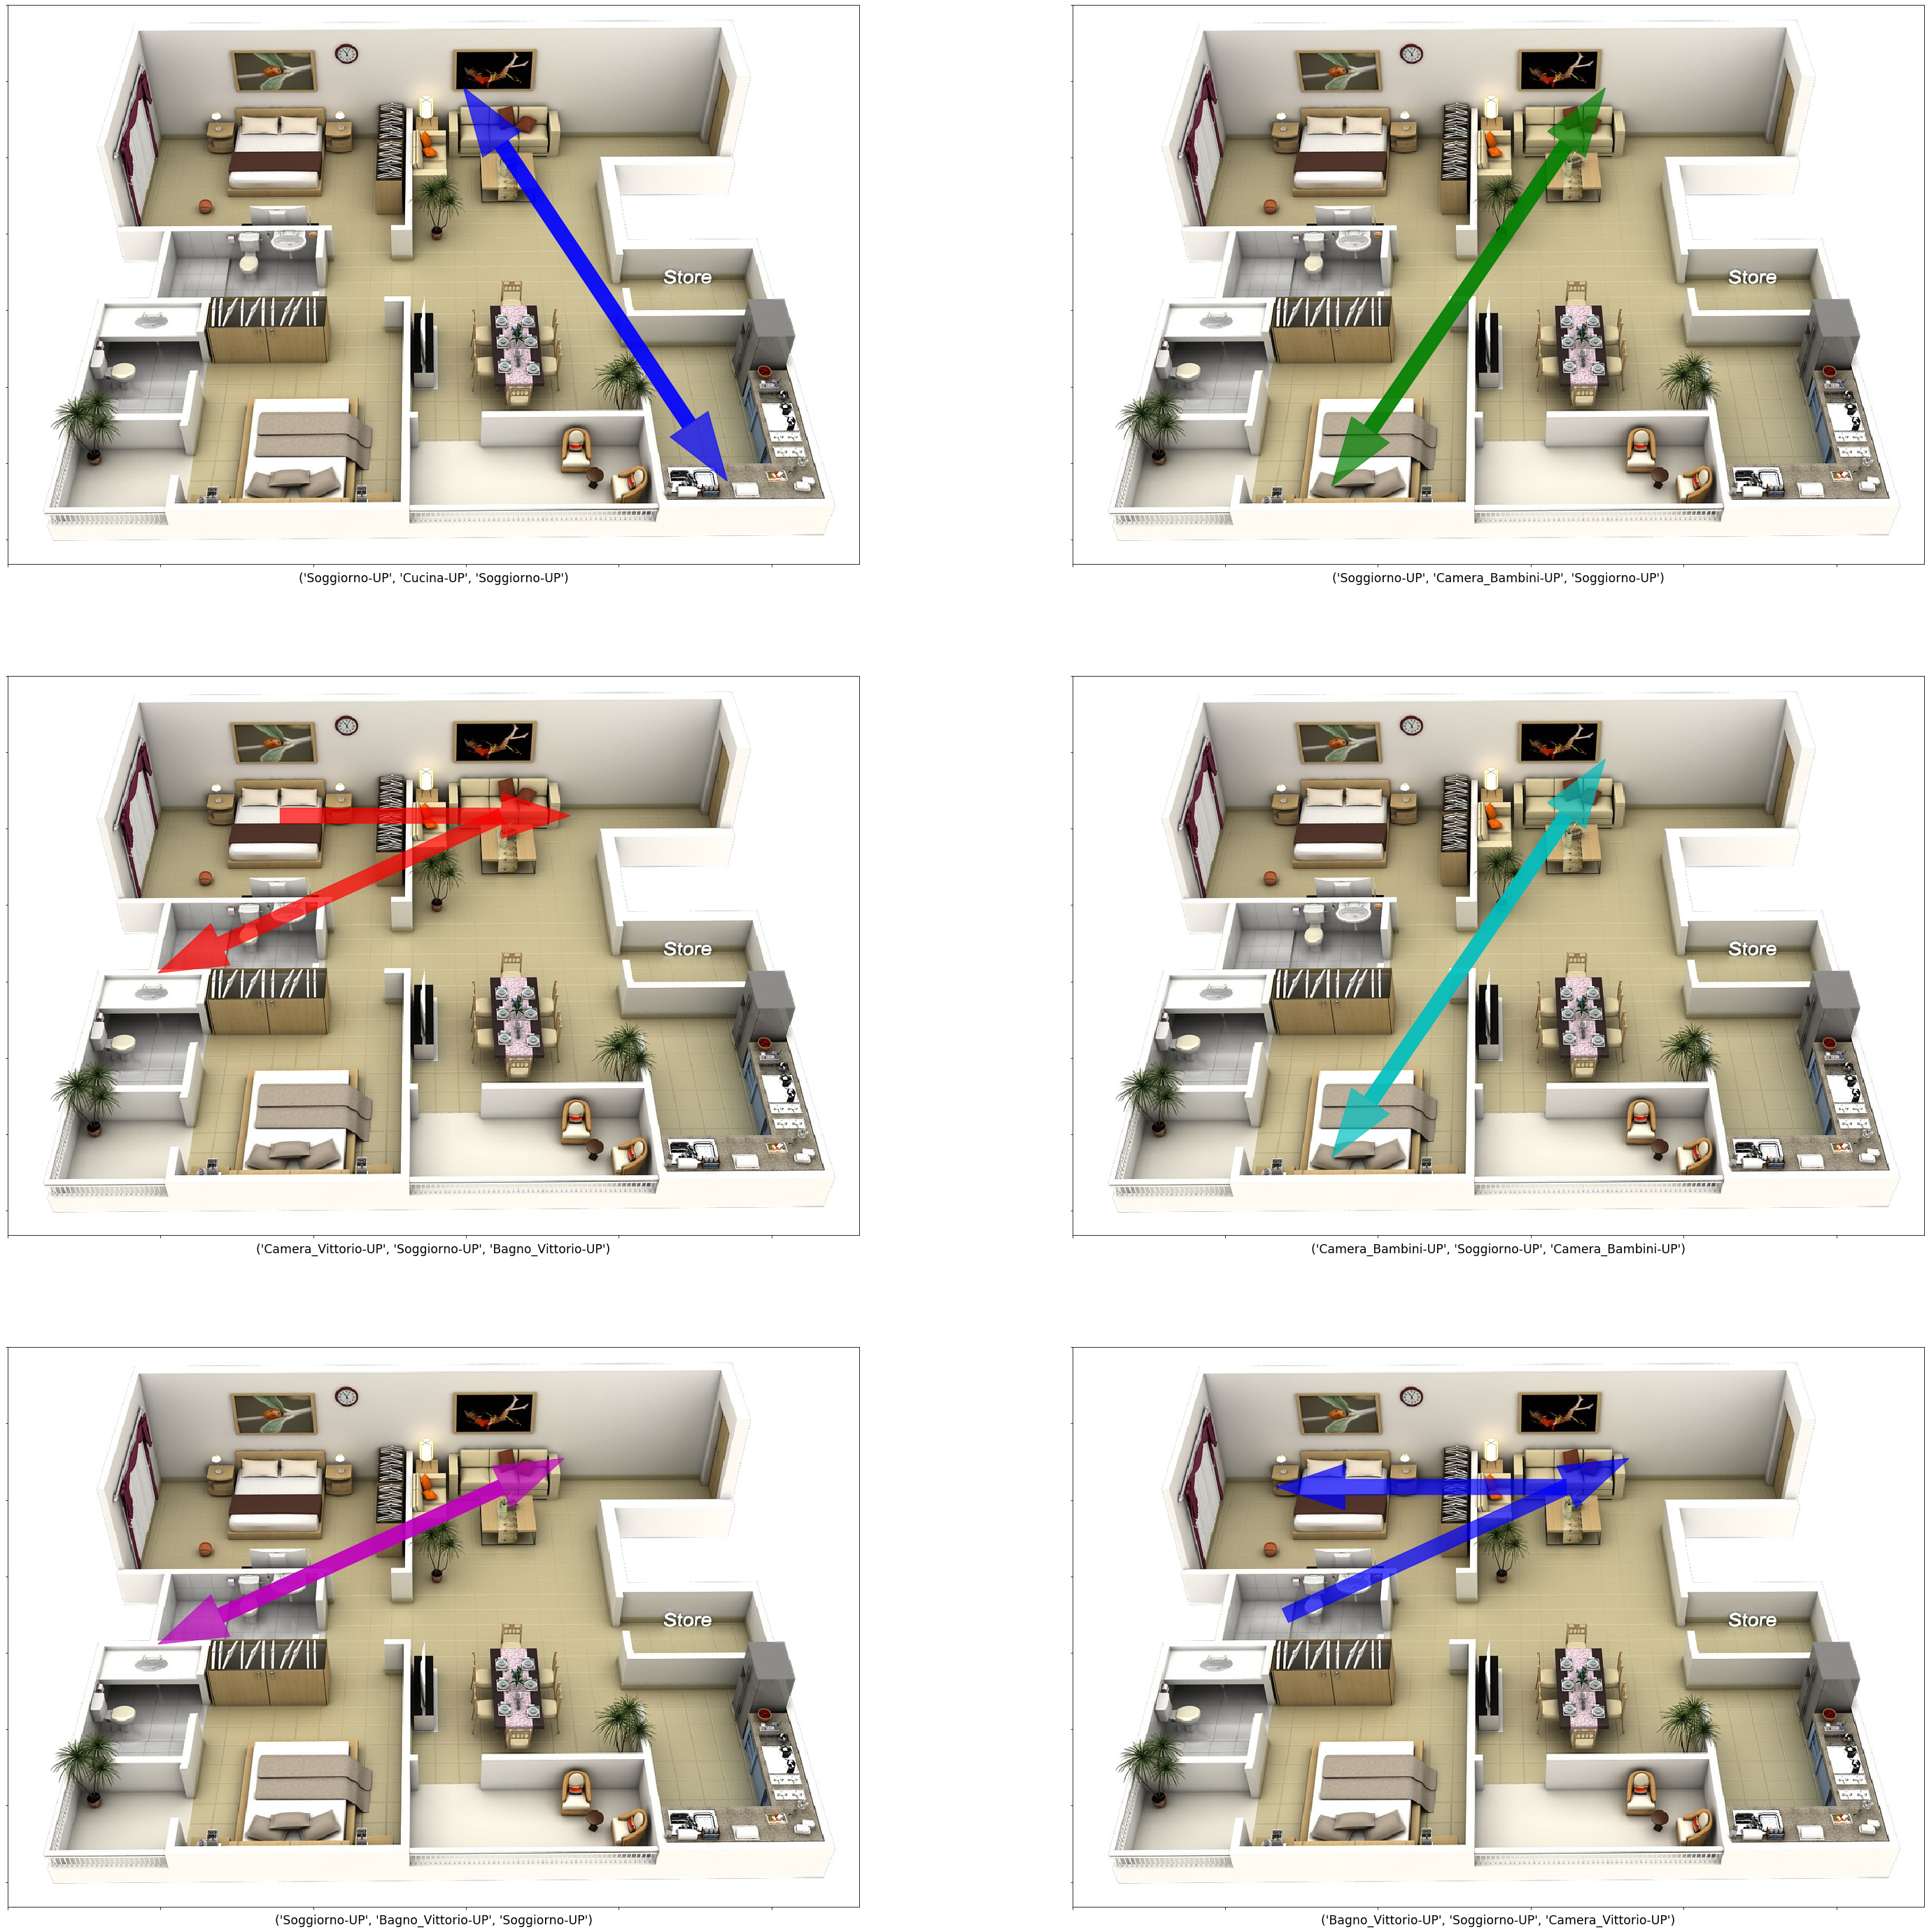

In [12]:
# Get first N most common vector
limit = 6

# Build x,t to imgx,imgy function
ticklx = np.linspace(0,100,5)
tickly = np.linspace(0,100,5)
xy2imgxy = lambda x,y: (img.size[0] * x / np.max(ticklx),\
                        img.size[1] * (np.max(tickly) - y) / np.max(tickly))
tickpx,tickpy = xy2imgxy(ticklx,tickly)

# Define color cycle
cycol = cycle('bgrcm')

# Create subplots
fig, axs = plt.subplots(limit // 2, 2, figsize=(50,50))

for r in range(limit // 2):
    for c in range(2):
        ax = axs[r,c]
        
        # Show image
        ax.imshow(img)

        # Rewrite x,y ticks lables
        ax.set_xticklabels([])
        ax.set_yticklabels([])
       
        # Get next color
        color = next(cycol)
        
        # Get vector row
        vector_row = df_vectors_count.iloc[r*2+c]
        
        # Build points list
        points = []
        for k in vector_row['vector']:
            room_name = k.split('-')[0]
            if room_name in rooms:
                points.append(rooms[room_name])
            else:
                break
                
        # Draw arrows        
        last_point = None
        for p in points:
            imgx, imgy = xy2imgxy(p[0],p[1])
            if last_point is None:
                last_point = (imgx, imgy) 
                continue
            dx, dy = imgx - last_point[0], imgy - last_point[1]
            ax.arrow(last_point[0], last_point[1], dx, dy, width=20,color=color,alpha=0.7)
            last_point = (imgx, imgy)    

        ax.set_xlabel(vector_row['vector'], fontsize='xx-large')    

        # Adjust the axis.
        ax.set_xlim(0,tickpx.max())
        ax.set_ylim(tickpy.max(),0)

plt.show()